# GluonTS - Transfer Learning Approach (quarterly) 

- Two datasets: A and B
- Dataset A: Dataset subsetted by frequency, i.e. `m4_yearly_atm`
- Dataset B: Dataset subsetted by frequency and by domain, i.e. `m4_yearly_industry`
- Network A: Trained on dataset A
- Network B: Trained on dataset B
- Both networks are evaluated on dataset B. 

- Adjust epochs to account for different size of the datasets

Goal: Check TZ1: "Does the network learn from time series of the same domain or is it helpful to use time series from other domains?"

- Both networks are trained for ten trials (deepar) or three trials (deepstate)

Note that there are already results where a network is trained on `m4_frequency_domain` and evaluated on the same network.

In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.7MB/s  eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 47.6MB/s ta 0:00:01
    100% |████████████████████████████████| 10.4MB 4.7MB/s  eta 0:00:01
    100% |████████████████████████████████| 7.3MB 6.6MB/s  eta 0:00:01
    100% |████████████████████████████████| 194kB 60.3MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 38.1MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 92kB 56.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/1f/fd/3a/f29866dc23dada18f25e9837477c82bbd7952aeef86fa46f11
Successfully built ujson holidays
  Found existing installation: python-dateut

## Imports



In [3]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [4]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar


INFO:root:Using CPU


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_end2003q3', 'm4_quarterly_end2013q1', 'm4_quarterly_end2015q1', 'm4_quarterly_finance', 'm4_quarterly_id

In [6]:
dataset = get_dataset("m4_weekly", regenerate=False)

INFO:root:downloading and processing m4_weekly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json


### mv the data

Before moving on: Move the respective data according the required folder structure. In AWS:

- `mv [dataname] ../../.mxnet/gluon-ts/datasets/`

## Check the data

In [7]:
dataname_a = "m4_yearly"
dataset_a = get_dataset(dataname_a, regenerate=False)
len(dataset_a.train)

INFO:root:downloading and processing m4_yearly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly/test/data.json


23000

In [8]:
dataname_b1 = "m4_yearly_macro"
dataset_b1 = get_dataset(dataname_b1, regenerate=False)
len(dataset_b1.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.


3903

In [9]:
dataname_b2 = "m4_yearly_micro"
dataset_b2 = get_dataset(dataname_b2, regenerate=False)
len(dataset_b2.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_micro.


6538

In [10]:
dataname_b3 = "m4_yearly_other"
dataset_b3 = get_dataset(dataname_b3, regenerate=False)
len(dataset_b3.train)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_other.


1236

### Dataset A


dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 23000
length test: 23000

start:
 1750-01-31 00:00:00
target:
 [5172.1 5133.5 5186.9 5084.6 5182.  5414.3 5576.2 5752.9 5955.2 6087.8]
feat_static_cat:
 [0]


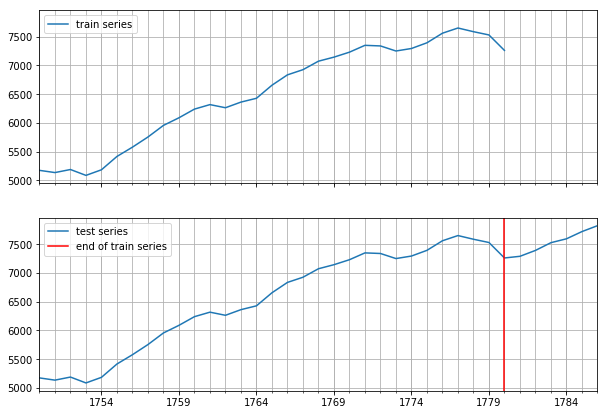

In [11]:
train_entry_a = next(iter(dataset_a.train))
test_entry_a = next(iter(dataset_a.test))

print(train_entry_a.keys())
print(test_entry_a.keys())
print("length train:", len(dataset_a.train))
print("length test:", len(dataset_a.test))


print("\nstart:\n",train_entry_a["start"])
print("target:\n", train_entry_a["target"][:10])
print("feat_static_cat:\n", train_entry_a["feat_static_cat"])

train_series_a = to_pandas(train_entry_a)
test_series_a = to_pandas(test_entry_a)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_a.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_a.plot(ax=ax[1])
ax[1].axvline(train_series_a.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Dataset B

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length train: 1236
length test: 1236

start:
 1750-01-31 00:00:00
target:
 [459. 543. 512. 443. 528. 644. 493. 493. 517. 395.]
feat_static_cat:
 [1]


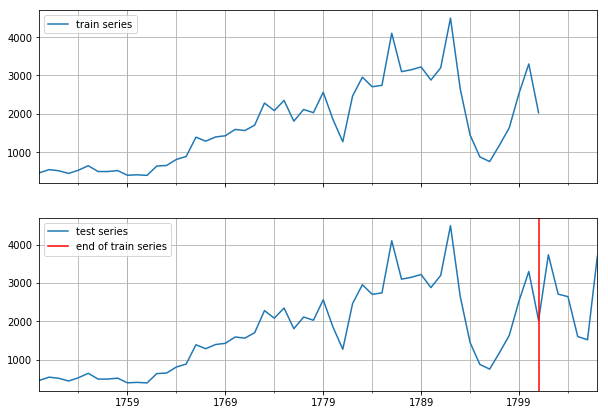

In [14]:
dataset_b = dataset_b3

train_entry_b = next(iter(dataset_b.train))
test_entry_b = next(iter(dataset_b.test))

print(train_entry_b.keys())
print(test_entry_b.keys())
print("length train:", len(dataset_b.train))
print("length test:", len(dataset_b.test))

print("\nstart:\n",train_entry_b["start"])
print("target:\n", train_entry_b["target"][:10])
print("feat_static_cat:\n", train_entry_b["feat_static_cat"])

train_series_b = to_pandas(train_entry_b)
test_series_b = to_pandas(test_entry_b)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series_b.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series_b.plot(ax=ax[1])
ax[1].axvline(train_series_b.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## Comparison of both datasets

- Compare whether both datasets have the same length


In [15]:
# Check length
print("Length test train:", len(dataset_a.train) == len(dataset_b.train))
print("Length test test:", len(dataset_a.test) == len(dataset_b.test))

# Check frequency
print("Frequency test:",(dataset_a.metadata.freq == dataset_b.metadata.freq))


Length test train: False
Length test test: False
Frequency test: True


## Modeling: DeepAR

In [16]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [17]:
# A: dataset_a
# B: dataset_b
print(dataset_a)
print("\n", dataset_b)

TrainDatasets(metadata=MetaData(freq='12M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='23000')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=6), train=<gluonts.dataset.common.FileDataset object at 0x7f956462ac88>, test=<gluonts.dataset.common.FileDataset object at 0x7f956462ab38>)

 TrainDatasets(metadata=MetaData(freq='12M', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat', cardinality='1236')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=6), train=<gluonts.dataset.common.FileDataset object at 0x7f956462a518>, test=<gluonts.dataset.common.FileDataset object at 0x7f9564eae518>)


In [18]:
print(dataname_a)
print(dataname_b1)

m4_yearly
m4_yearly_macro


In [19]:
def deepar_train_eval(dataname_a, dataname_b, seed=42, epochs=100, num_batches=100):
    """
    Function that trains a network using data from dataset B and evaluates the trained network on dataset A.
    Dataset A is the dataset of interest for our analysis. 
    """    
    
    dataset_a = get_dataset(dataname_a, regenerate=False)
    dataset_b = get_dataset(dataname_b, regenerate=False)
    
    # Assert checks
    assert (dataset_a.metadata.freq == dataset_b.metadata.freq)
#     assert ( len(dataset_a.train)==len(dataset_b.train) )
#     assert ( len(dataset_a.test)==len(dataset_b.test))
    
    mx.random.seed(seed)
    np.random.seed(seed)

    # define trainer
    trainer=Trainer(
        ctx=mx.cpu(),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
    )

    estimator=DeepAREstimator(
        trainer=trainer,
        context_length=dataset_a.metadata.prediction_length,
        prediction_length=dataset_a.metadata.prediction_length,
        freq=dataset_a.metadata.freq,
        use_feat_static_cat=False,
    )
    
#     estimator = DeepAREstimator(
#         trainer=trainer,
#         cardinality= [
#             feat_static_cat.cardinality 
#             for feat_static_cat in dataset_a.metadata.feat_static_cat
#         ],
#         context_length=dataset_a.metadata.prediction_length,
#         prediction_length=dataset_a.metadata.prediction_length,
#         freq=dataset_a.metadata.freq,
#         use_feat_static_cat=True
#     )
    
    # predictor trained on dataset_a, evaluated on dataset_b
    predictor_a=estimator.train(training_data=dataset_a.train)
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset_b.test, predictor=predictor_a, num_samples=100
    )
    
    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series = len(dataset_b.test))
    
    metrics=["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}
    
    output["seed"]=seed
    output["epochs"]=epochs
    output["num_batches"]=num_batches
    output["train data"]=dataname_a
    output["eval data"]=dataname_b
    
    df=pd.DataFrame([output])

    return df

    

## Subsets

In [20]:
print(dataname_a)
print(dataname_b1)

m4_yearly
m4_yearly_macro


## Study 1: `m4_yearly` vs. `m4_yearly_macro` trained network

- Alternating between Run I - 10 trials A:B vs. 
- Run II - 10 trials of B:B


In [21]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

Next seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 50/50 [00:00<00:00, 58.21it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 0.861 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.504471
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.43it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.766 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.886298
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.28it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[2] Elapsed time 0.694 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.110143
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 67.96it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 0.738 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389315
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.32it/s, avg_epoch_loss=6.52]
INFO:

INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 83.32it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[37] Elapsed time 0.602 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.376101
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.40it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[38] Elapsed time 0.683 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.207918
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.17it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 0.633 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.731974
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.26it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.619 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.960153
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.69it/s, avg_epoch_loss=7.24]
IN

100%|██████████| 50/50 [00:00<00:00, 73.89it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[73] Elapsed time 0.681 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.037563
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 83.76it/s, avg_epoch_loss=6.03]
INFO:root:Epoch[74] Elapsed time 0.599 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.026823
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.03it/s, avg_epoch_loss=6.1]
INFO:root:Epoch[75] Elapsed time 0.737 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.097772
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 82.01it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[76] Elapsed time 0.612 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.450733
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 78.49it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[77] Elapsed time 0.638 seconds
INFO:root

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.873822  0.169934  98.471798            0.157983            0.095998   

   seed  epochs  num_batches train data        eval data  
0    42     100           50  m4_yearly  m4_yearly_macro  
Next seed: 43


100%|██████████| 50/50 [00:00<00:00, 63.06it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[0] Elapsed time 0.795 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.361025
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.42it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 0.631 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.99it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[2] Elapsed time 0.590 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.117778
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.72it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.629 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.468842
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.24it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.694 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 74.71it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[37] Elapsed time 0.671 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.516047
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 77.92it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[38] Elapsed time 0.643 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.276766
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 76.77it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.653 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.862285
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.72it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[40] Elapsed time 0.629 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.148069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.23it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[41] Elapsed time 0.666 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.025125
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.71it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[74] Elapsed time 0.690 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.142846
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.92it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.661 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.197944
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 67.38it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[76] Elapsed time 0.744 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.675696
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 66.90it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[77] Elapsed time 0.749 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.257240
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.42774  0.167826  87.146765            0.155703            0.111971    43   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_macro  
Next seed: 44


100%|██████████| 50/50 [00:00<00:00, 74.32it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[0] Elapsed time 0.674 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.390623
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 80.41it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[1] Elapsed time 0.623 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.837493
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.24it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 0.649 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.131030
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.72it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.637 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.474072
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.52it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[4] Elapsed time 0.721 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 81.74it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.613 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.535886
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.13it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[38] Elapsed time 0.685 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.199467
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.67it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[39] Elapsed time 0.741 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.890546
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 69.30it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[40] Elapsed time 0.725 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.893149
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.93it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.727 seconds
I

100%|██████████| 50/50 [00:00<00:00, 68.49it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[73] Elapsed time 0.732 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.040508
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 83.57it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[74] Elapsed time 0.600 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.140932
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 76.15it/s, avg_epoch_loss=6.14]
INFO:root:Epoch[75] Elapsed time 0.658 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.139855
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 80.49it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[76] Elapsed time 0.624 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.468960
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 80.69it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[77] Elapsed time 0.621 seconds
INFO:roo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.745886  0.151625  60.038955            0.143596            0.100495   

   seed  epochs  num_batches train data        eval data  
0    44     100           50  m4_yearly  m4_yearly_macro  
Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 64.12it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 0.782 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 78.05it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 0.642 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.69it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.709 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.218781
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.63it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.710 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.558501
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 74.68it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.671 seconds
INFO:root:Epoch[4] Ev

KeyboardInterrupt: 

In [22]:
results

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,4.873822,0.169934,98.471798,0.157983,0.095998,42,100,50,m4_yearly,m4_yearly_macro
0,4.427740,0.167826,87.146765,0.155703,0.111971,43,100,50,m4_yearly,m4_yearly_macro
0,3.745886,0.151625,60.038955,0.143596,0.100495,44,100,50,m4_yearly,m4_yearly_macro


In [23]:
results = pd.DataFrame()

for i in range(45,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 45


100%|██████████| 50/50 [00:00<00:00, 65.86it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 0.761 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 73.46it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 0.683 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 76.83it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[2] Elapsed time 0.653 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.218781
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 77.32it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.649 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.558501
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.75it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.629 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 81.94it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.612 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.663585
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 87.79it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[38] Elapsed time 0.571 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.352268
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.60it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.638 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.060494
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.95it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.749 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.071069
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 81.96it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[41] Elapsed time 0.612 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.073140
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.89it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 0.661 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.169389
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.38it/s, avg_epoch_loss=6.2]
INFO:root:Epoch[75] Elapsed time 0.733 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.203270
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.43it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 0.734 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.642127
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 73.88it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[77] Elapsed time 0.679 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.315003
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.836294  0.159838  65.677807            0.152487            0.107728   

   seed  epochs  num_batches train data        eval data  
0    45     100           50  m4_yearly  m4_yearly_macro  
Next seed: 46


100%|██████████| 50/50 [00:00<00:00, 74.26it/s, avg_epoch_loss=8.45]
INFO:root:Epoch[0] Elapsed time 0.675 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.454084
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 65.70it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[1] Elapsed time 0.762 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.777933
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.23it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.602 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.099694
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.45it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[3] Elapsed time 0.601 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.469341
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 70.75it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.708 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 73.79it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[37] Elapsed time 0.680 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.572787
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.86it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[38] Elapsed time 0.679 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.222297
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.69it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[39] Elapsed time 0.752 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.835304
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.80it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[40] Elapsed time 0.739 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.937070
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 65.87it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.762 seconds


INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.144706
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.78it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[74] Elapsed time 0.708 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.354326
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.76it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[75] Elapsed time 0.689 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.107741
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 81.39it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 0.616 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.508827
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.84it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[77] Elapsed time 0.646 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.150474
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.194961  0.158159  61.299902            0.147884            0.093843   

   seed  epochs  num_batches train data        eval data  
0    46     100           50  m4_yearly  m4_yearly_macro  
Next seed: 47


100%|██████████| 50/50 [00:00<00:00, 67.01it/s, avg_epoch_loss=8.3]
INFO:root:Epoch[0] Elapsed time 0.748 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.300957
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.68it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[1] Elapsed time 0.730 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.953688
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.90it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[2] Elapsed time 0.697 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.185384
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.59it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[3] Elapsed time 0.691 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.618228
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 69.92it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[4] Elapsed time 0.717 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 72.45it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[37] Elapsed time 0.692 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.542198
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.96it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.707 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310337
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 64.40it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[39] Elapsed time 0.778 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.857199
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 66.49it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[40] Elapsed time 0.754 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.966600
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 68.75it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[41] Elapsed time 0.729 seconds


100%|██████████| 50/50 [00:00<00:00, 68.48it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[73] Elapsed time 0.732 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.127231
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 71.24it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[74] Elapsed time 0.704 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.093835
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.08it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 0.652 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.131638
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.59it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 0.731 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.556375
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.95it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[77] Elapsed time 0.727 seconds
INFO:roo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.919448  0.154117  58.202187            0.146222             0.09572   

   seed  epochs  num_batches train data        eval data  
0    47     100           50  m4_yearly  m4_yearly_macro  
Next seed: 48


100%|██████████| 50/50 [00:00<00:00, 63.70it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 0.787 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.259591
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 71.52it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[1] Elapsed time 0.701 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.809849
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 85.57it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[2] Elapsed time 0.586 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.096091
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 86.86it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 0.577 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.460881
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 72.24it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[4] Elapsed time 0.694 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 85.62it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[37] Elapsed time 0.586 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.604694
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.98it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[38] Elapsed time 0.660 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.310488
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 67.10it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[39] Elapsed time 0.747 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.830231
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 76.03it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[40] Elapsed time 0.659 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.962990
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 72.23it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[41] Elapsed time 0.694 seconds
I

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.063190
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 85.60it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[74] Elapsed time 0.586 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.209669
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 86.49it/s, avg_epoch_loss=6.09]
INFO:root:Epoch[75] Elapsed time 0.580 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.085264
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.47it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[76] Elapsed time 0.648 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.411025
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 68.21it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[77] Elapsed time 0.735 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.138513
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.572974  0.149084  57.436386            0.142474            0.100498   

   seed  epochs  num_batches train data        eval data  
0    48     100           50  m4_yearly  m4_yearly_macro  
Next seed: 49


100%|██████████| 50/50 [00:00<00:00, 75.30it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 0.666 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.047287
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.40it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[1] Elapsed time 0.631 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.824245
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.08it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[2] Elapsed time 0.603 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.147297
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.56it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[3] Elapsed time 0.615 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.529483
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.17it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[4] Elapsed time 0.633 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 69.46it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[37] Elapsed time 0.722 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.662529
INFO:root:Loading parameters from best epoch (17)
INFO:root:Epoch[38] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 72.73it/s, avg_epoch_loss=7.51]
INFO:root:Epoch[38] Elapsed time 0.689 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.508654
INFO:root:Epoch[39] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 66.85it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[39] Elapsed time 0.749 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.264403
INFO:root:Epoch[40] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 69.52it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[40] Elapsed time 0.721 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.157419
INFO:root:Epoch[41] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 79.80it/s, avg_epoch_loss

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.127874
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 80.32it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 0.624 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301678
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.65it/s, avg_epoch_loss=6.24]
INFO:root:Epoch[75] Elapsed time 0.646 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.235435
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 75.91it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 0.661 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.847978
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 71.40it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[77] Elapsed time 0.702 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.381353
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/50

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.526131  0.17208  79.288044            0.159145            0.104804    49   

   epochs  num_batches train data        eval data  
0     100           50  m4_yearly  m4_yearly_macro  
Next seed: 50


100%|██████████| 50/50 [00:01<00:00, 47.83it/s, avg_epoch_loss=8.7]
INFO:root:Epoch[0] Elapsed time 1.047 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.698136
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.46it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[1] Elapsed time 0.993 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.967265
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.86it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[2] Elapsed time 0.930 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.261159
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 68.11it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[3] Elapsed time 0.736 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.563689
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 82.56it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[4] Elapsed time 0.608 seconds
INFO:root:Epoch[4] Eva

100%|██████████| 50/50 [00:00<00:00, 82.25it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[37] Elapsed time 0.610 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.581845
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 85.36it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[38] Elapsed time 0.587 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.355415
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.88it/s, avg_epoch_loss=7.06]
INFO:root:Epoch[39] Elapsed time 0.661 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.056478
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 73.10it/s, avg_epoch_loss=7]
INFO:root:Epoch[40] Elapsed time 0.686 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.003124
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 70.72it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[41] Elapsed time 0.710 seconds
INF

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.167244
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 77.86it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[74] Elapsed time 0.644 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.716728
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 76.30it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 0.657 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.126387
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 70.03it/s, avg_epoch_loss=6.29]
INFO:root:Epoch[76] Elapsed time 0.716 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.293392
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 72.49it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[77] Elapsed time 0.691 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=7.030072
INFO:root:Epoch[78] Learning rate is 5e-05
100%|██████████| 50/5

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.138342  0.158813  63.096871            0.148078            0.102241   

   seed  epochs  num_batches train data        eval data  
0    50     100           50  m4_yearly  m4_yearly_macro  
Next seed: 51


100%|██████████| 50/50 [00:00<00:00, 64.85it/s, avg_epoch_loss=8.27]
INFO:root:Epoch[0] Elapsed time 0.773 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.266300
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.60it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[1] Elapsed time 0.630 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.862214
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 83.72it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 0.599 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.180719
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 84.41it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 0.594 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.548719
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 79.69it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[4] Elapsed time 0.629 seconds
INFO:root:Epoch[4] Ev

100%|██████████| 50/50 [00:00<00:00, 88.82it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[37] Elapsed time 0.566 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=7.420615
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 79.90it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[38] Elapsed time 0.630 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.273554
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 80.01it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[39] Elapsed time 0.627 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.811695
INFO:root:Epoch[40] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 75.34it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 0.666 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.068080
INFO:root:Epoch[41] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 78.37it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[41] Elapsed time 0.640 seconds


100%|██████████| 50/50 [00:00<00:00, 78.36it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[73] Elapsed time 0.640 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=7.240384
INFO:root:Epoch[74] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 76.14it/s, avg_epoch_loss=6.35]
INFO:root:Epoch[74] Elapsed time 0.659 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.354566
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 74.29it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[75] Elapsed time 0.675 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.131544
INFO:root:Epoch[76] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 79.87it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[76] Elapsed time 0.628 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.429161
INFO:root:Epoch[77] Learning rate is 5e-05
100%|██████████| 50/50 [00:00<00:00, 69.03it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[77] Elapsed time 0.728 seconds
INFO:root

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.280086  0.164888  73.323555            0.153623            0.114102   

   seed  epochs  num_batches train data        eval data  
0    51     100           50  m4_yearly  m4_yearly_macro  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,3.836294,0.159838,65.677807,0.152487,0.107728,45,100,50,m4_yearly,m4_yearly_macro
0,4.194961,0.158159,61.299902,0.147884,0.093843,46,100,50,m4_yearly,m4_yearly_macro
0,3.919448,0.154117,58.202187,0.146222,0.095720,47,100,50,m4_yearly,m4_yearly_macro
0,3.572974,0.149084,57.436386,0.142474,0.100498,48,100,50,m4_yearly,m4_yearly_macro
0,4.526131,0.172080,79.288044,0.159145,0.104804,49,100,50,m4_yearly,m4_yearly_macro
0,4.138342,0.158813,63.096871,0.148078,0.102241,50,100,50,m4_yearly,m4_yearly_macro
0,4.280086,0.164888,73.323555,0.153623,0.114102,51,100,50,m4_yearly,m4_yearly_macro


In [24]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_macro", dataname_b="m4_yearly_macro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 50/50 [00:01<00:00, 39.82it/s, avg_epoch_loss=8.5]
INFO:root:Epoch[0] Elapsed time 1.265 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.504471
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.61it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 1.238 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.886298
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.97it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[2] Elapsed time 1.288 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.528871
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.83it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 1.229 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.243482
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.99it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[4] Elapsed time 1.142 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.80it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[38] Elapsed time 1.029 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.855072
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.74it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[39] Elapsed time 1.101 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.500729
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.00it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[40] Elapsed time 1.121 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.847092
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.28it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 1.043 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.626360
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.24it/s, avg_epoch_loss=6.64]
INFO:root:Epo

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.546456
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.84it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[75] Elapsed time 1.011 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.733102
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 44.06it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 1.142 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.549674
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.18it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 1.023 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.734246
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 46.76it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[78] Elapsed time 1.076 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.606805
INFO:root:Epoch[79] Learning rate is 0.000125
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.590866  0.149578  43.737675            0.144425            0.090885   

   seed  epochs  num_batches       train data        eval data  
0    42     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 43


100%|██████████| 50/50 [00:01<00:00, 39.46it/s, avg_epoch_loss=8.36]
INFO:root:Epoch[0] Elapsed time 1.277 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.361025
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 39.52it/s, avg_epoch_loss=7.89]
INFO:root:Epoch[1] Elapsed time 1.272 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.887139
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.51it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[2] Elapsed time 1.182 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.617197
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 39.71it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[3] Elapsed time 1.263 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.389342
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.99it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[4] Elapsed time 1.222 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 50.74it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[38] Elapsed time 0.999 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.787858
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.92it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 1.072 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.615798
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.14it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[40] Elapsed time 1.089 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.763866
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.15it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 1.046 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.658478
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 49.88it/s, avg_epoch_loss=6.64]
INFO:root:Ep

INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 46.54it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[75] Elapsed time 1.077 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.645158
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 44.85it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[76] Elapsed time 1.117 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.625839
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 48.56it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[77] Elapsed time 1.032 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.717467
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 46.56it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[78] Elapsed time 1.079 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.610165
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 50/

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.081259  0.158196  44.795925            0.150643            0.092845   

   seed  epochs  num_batches       train data        eval data  
0    43     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 44


100%|██████████| 50/50 [00:01<00:00, 38.76it/s, avg_epoch_loss=8.39]
INFO:root:Epoch[0] Elapsed time 1.296 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.390623
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.17it/s, avg_epoch_loss=7.84]
INFO:root:Epoch[1] Elapsed time 1.136 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.837493
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.02it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[2] Elapsed time 1.168 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.550150
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.70it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[3] Elapsed time 1.151 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.354536
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.19it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 1.087 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.21it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[38] Elapsed time 0.944 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.716108
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.43it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 1.159 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.616909
INFO:root:Loading parameters from best epoch (29)
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 48.61it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[40] Elapsed time 1.039 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.811277
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.93it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[41] Elapsed time 1.096 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.565581
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████| 50/50 [00:0

100%|██████████| 50/50 [00:00<00:00, 55.24it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[74] Elapsed time 0.910 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.827021
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 53.15it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 0.943 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.556941
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 53.40it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[76] Elapsed time 0.941 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.799302
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 50.88it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[77] Elapsed time 0.988 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.692725
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 51.02it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[78] Elapsed time 0.986 secon

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.832858  0.154452  44.549895            0.145451             0.09271   

   seed  epochs  num_batches       train data        eval data  
0    44     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 45


100%|██████████| 50/50 [00:01<00:00, 38.84it/s, avg_epoch_loss=8.35]
INFO:root:Epoch[0] Elapsed time 1.293 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.351627
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.31it/s, avg_epoch_loss=8.02]
INFO:root:Epoch[1] Elapsed time 1.218 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=8.021420
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.54it/s, avg_epoch_loss=7.67]
INFO:root:Epoch[2] Elapsed time 1.210 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.674155
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.37it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[3] Elapsed time 1.245 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.340696
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.33it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 1.086 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 51.10it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[38] Elapsed time 0.984 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.755956
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.62it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[39] Elapsed time 1.075 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.534364
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.03it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[40] Elapsed time 1.046 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.780971
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 48.21it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[41] Elapsed time 1.044 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.595433
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.37it/s, avg_epoch_loss=6.59]
INFO:root:Epo

100%|██████████| 50/50 [00:01<00:00, 47.83it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[75] Elapsed time 1.051 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.655850
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:00<00:00, 50.05it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[76] Elapsed time 1.001 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.607532
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.63it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 1.101 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.730082
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 46.52it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[78] Elapsed time 1.080 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.535313
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 44.48it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[79] Elapsed time 1.126 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.188881  0.144695  40.008877            0.139085            0.093087   

   seed  epochs  num_batches       train data        eval data  
0    45     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 46


100%|██████████| 50/50 [00:01<00:00, 38.54it/s, avg_epoch_loss=8.45]
INFO:root:Epoch[0] Elapsed time 1.307 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.454084
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.71it/s, avg_epoch_loss=7.78]
INFO:root:Epoch[1] Elapsed time 1.202 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.777933
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.29it/s, avg_epoch_loss=7.52]
INFO:root:Epoch[2] Elapsed time 1.131 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.519982
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.72it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[3] Elapsed time 1.203 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.360375
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.57it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[4] Elapsed time 1.153 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.91it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[38] Elapsed time 1.073 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.832847
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.05it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[39] Elapsed time 1.117 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.542996
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.66it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[40] Elapsed time 1.102 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.763059
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.89it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[41] Elapsed time 1.051 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.695802
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 52.61it/s, avg_epoch_loss=6.56]
INFO:root:Epo

INFO:root:Loading parameters from best epoch (44)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.49it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[75] Elapsed time 1.014 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.638952
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.69it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 1.032 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.551478
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 51.96it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[77] Elapsed time 0.966 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.729809
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 45.04it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[78] Elapsed time 1.116 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.500993
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  5.004783  0.173669  51.742147            0.166835            0.094568   

   seed  epochs  num_batches       train data        eval data  
0    46     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 47


100%|██████████| 50/50 [00:01<00:00, 40.72it/s, avg_epoch_loss=8.3]
INFO:root:Epoch[0] Elapsed time 1.238 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.300957
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.58it/s, avg_epoch_loss=7.95]
INFO:root:Epoch[1] Elapsed time 1.209 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.953688
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.30it/s, avg_epoch_loss=7.68]
INFO:root:Epoch[2] Elapsed time 1.163 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.678887
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.14it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[3] Elapsed time 1.252 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.495128
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 47.63it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[4] Elapsed time 1.055 seconds
INFO:root:Epoch[4] Eval

INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.715062
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 41.52it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[38] Elapsed time 1.206 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.846320
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.50it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[39] Elapsed time 1.101 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.705190
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.38it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[40] Elapsed time 1.015 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.818907
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.94it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[41] Elapsed time 1.006 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.659842
INFO:root:Epoch[42] Learning rate is 0.0005
100%|██████████|

100%|██████████| 50/50 [00:01<00:00, 45.71it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[74] Elapsed time 1.097 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.716671
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:00<00:00, 51.70it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[75] Elapsed time 0.972 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.752691
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 41.38it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[76] Elapsed time 1.218 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.650317
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 45.55it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[77] Elapsed time 1.103 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.860934
INFO:root:Epoch[78] Learning rate is 6.25e-05
100%|██████████| 50/50 [00:01<00:00, 44.46it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[78] Elapsed time 1.133 secon

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.596029  0.165968  45.946124            0.152793              0.0916   

   seed  epochs  num_batches       train data        eval data  
0    47     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 48


100%|██████████| 50/50 [00:01<00:00, 39.62it/s, avg_epoch_loss=8.26]
INFO:root:Epoch[0] Elapsed time 1.268 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.259591
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.22it/s, avg_epoch_loss=7.81]
INFO:root:Epoch[1] Elapsed time 1.164 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.809850
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.18it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[2] Elapsed time 1.136 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.480297
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.28it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[3] Elapsed time 1.186 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.284674
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.14it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[4] Elapsed time 1.137 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.30it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[38] Elapsed time 1.137 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.826883
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.36it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[39] Elapsed time 1.217 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.541915
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.97it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[40] Elapsed time 1.068 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.765311
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 53.58it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[41] Elapsed time 0.939 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.628874
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.96it/s, avg_epoch_loss=6.6]
INFO:root:Epo

INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.626361
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 48.65it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[75] Elapsed time 1.033 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.632448
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 54.24it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[76] Elapsed time 0.932 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.546485
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 58.40it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[77] Elapsed time 0.862 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.772388
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 55.83it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[78] Elapsed time 0.902 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.481043
INFO:root:Epoch[79] Learning rate is 0.000125
100%|█

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.213648  0.161166  46.280665            0.154653            0.091641   

   seed  epochs  num_batches       train data        eval data  
0    48     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 49


100%|██████████| 50/50 [00:01<00:00, 39.27it/s, avg_epoch_loss=8.05]
INFO:root:Epoch[0] Elapsed time 1.278 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.047287
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.79it/s, avg_epoch_loss=7.82]
INFO:root:Epoch[1] Elapsed time 1.231 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.824245
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.49it/s, avg_epoch_loss=7.56]
INFO:root:Epoch[2] Elapsed time 1.179 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.558052
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.87it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[3] Elapsed time 1.171 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.451529
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.05it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[4] Elapsed time 1.165 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.78it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 1.125 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.773589
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.85it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[39] Elapsed time 1.202 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.586556
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.40it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[40] Elapsed time 1.211 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.810405
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.58it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[41] Elapsed time 1.123 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.592515
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.59it/s, avg_epoch_loss=6.69]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 53.19it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[75] Elapsed time 0.946 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.556395
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 49.69it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 1.013 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.643206
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 46.55it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[77] Elapsed time 1.081 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.605855
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 41.97it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[78] Elapsed time 1.196 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.580163
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 49.20it/s, avg_epoch_loss=6.78

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.934547  0.154647  43.659883            0.150907            0.092473   

   seed  epochs  num_batches       train data        eval data  
0    49     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 50


100%|██████████| 50/50 [00:01<00:00, 40.03it/s, avg_epoch_loss=8.7]
INFO:root:Epoch[0] Elapsed time 1.261 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.698136
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 38.64it/s, avg_epoch_loss=7.97]
INFO:root:Epoch[1] Elapsed time 1.307 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.967265
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.99it/s, avg_epoch_loss=7.71]
INFO:root:Epoch[2] Elapsed time 1.170 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.706051
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.75it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[3] Elapsed time 1.232 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.478264
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.80it/s, avg_epoch_loss=7.47]
INFO:root:Epoch[4] Elapsed time 1.175 seconds
INFO:root:Epoch[4] Eva

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 44.80it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[38] Elapsed time 1.122 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.771320
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.98it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[39] Elapsed time 1.143 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.677053
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.52it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[40] Elapsed time 1.155 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.689990
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.10it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[41] Elapsed time 1.093 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.701246
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.27it/s, avg_epoch_loss=6.66]
INFO:root:Epo

INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 49.08it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[75] Elapsed time 1.026 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.847404
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:00<00:00, 50.07it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[76] Elapsed time 1.003 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.536902
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 46.26it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[77] Elapsed time 1.086 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.697777
INFO:root:Epoch[78] Learning rate is 0.000125
100%|██████████| 50/50 [00:01<00:00, 46.59it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[78] Elapsed time 1.079 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.767573
INFO:root:Epoch[79] Learning rate is 0.000125
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  4.315619  0.162161  48.859384            0.153887            0.090162   

   seed  epochs  num_batches       train data        eval data  
0    50     100           50  m4_yearly_macro  m4_yearly_macro  
Next seed: 51


100%|██████████| 50/50 [00:01<00:00, 38.88it/s, avg_epoch_loss=8.27]
INFO:root:Epoch[0] Elapsed time 1.293 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.266300
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.19it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[1] Elapsed time 1.247 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.862214
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 43.41it/s, avg_epoch_loss=7.58]
INFO:root:Epoch[2] Elapsed time 1.158 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.582373
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 40.19it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[3] Elapsed time 1.248 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.380957
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 45.44it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[4] Elapsed time 1.103 seconds
INFO:root:Epoch[4] Ev

INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 46.29it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[38] Elapsed time 1.085 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.689464
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.87it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[39] Elapsed time 1.201 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.552888
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 41.97it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[40] Elapsed time 1.198 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.713320
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.80it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[41] Elapsed time 1.175 seconds
INFO:root:Epoch[41] Evaluation metric 'epoch_loss'=6.562104
INFO:root:Epoch[42] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 42.98it/s, avg_epoch_loss=6.64]
INFO:root:Ep

100%|██████████| 50/50 [00:00<00:00, 52.66it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[75] Elapsed time 0.953 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.620134
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:01<00:00, 45.59it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[76] Elapsed time 1.101 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.505375
INFO:root:Loading parameters from best epoch (56)
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 50.42it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 0.996 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.683092
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 50/50 [00:01<00:00, 44.68it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[78] Elapsed time 1.127 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=6.512639
INFO:root:Epoch[79] Learning rate is 0.00025
100%|██████████| 50/50 [00:00<00:00, 53.40it/s, avg_epoch_loss=6.73

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.376449  0.14771  40.443079            0.144548            0.094532    51   

   epochs  num_batches       train data        eval data  
0     100           50  m4_yearly_macro  m4_yearly_macro  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,3.590866,0.149578,43.737675,0.144425,0.090885,42,100,50,m4_yearly_macro,m4_yearly_macro
0,4.081259,0.158196,44.795925,0.150643,0.092845,43,100,50,m4_yearly_macro,m4_yearly_macro
0,3.832858,0.154452,44.549895,0.145451,0.092710,44,100,50,m4_yearly_macro,m4_yearly_macro
0,3.188881,0.144695,40.008877,0.139085,0.093087,45,100,50,m4_yearly_macro,m4_yearly_macro
0,5.004783,0.173669,51.742147,0.166835,0.094568,46,100,50,m4_yearly_macro,m4_yearly_macro
0,4.596029,0.165968,45.946124,0.152793,0.091600,47,100,50,m4_yearly_macro,m4_yearly_macro
0,4.213648,0.161166,46.280665,0.154653,0.091641,48,100,50,m4_yearly_macro,m4_yearly_macro
0,3.934547,0.154647,43.659883,0.150907,0.092473,49,100,50,m4_yearly_macro,m4_yearly_macro
0,4.315619,0.162161,48.859384,0.153887,0.090162,50,100,50,m4_yearly_macro,m4_yearly_macro
0,3.376449,0.147710,40.443079,0.144548,0.094532,51,100,50,m4_yearly_macro,m4_yearly_macro


In [25]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:02<00:00, 41.25it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 2.429 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.195385
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.00it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[1] Elapsed time 2.279 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.749729
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.92it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 2.396 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.795460
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.70it/s, avg_epoch_loss=7.17]
INFO:root:Epoch[3] Elapsed time 2.348 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.165579
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.65it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[4] Elapsed time 2.198 seconds
INFO:root:Epo

100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[37] Elapsed time 1.899 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.681227
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.31it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[38] Elapsed time 2.120 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.385415
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.61it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[39] Elapsed time 2.199 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.678085
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.94it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[40] Elapsed time 2.048 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.102784
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 48.09it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[41] Elapsed time 2.087 seconds

100%|██████████| 100/100 [00:02<00:00, 43.33it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[73] Elapsed time 2.315 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.657541
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41.33it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[74] Elapsed time 2.422 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.468874
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.53it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 2.306 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.741548
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 44.47it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[76] Elapsed time 2.256 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.952458
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.59it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:02<00:00, 44.03it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[109] Elapsed time 2.277 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.781739
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.66it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[110] Elapsed time 2.350 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.581448
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.12it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[111] Elapsed time 2.173 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.898713
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.59it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[112] Elapsed time 2.023 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.733637
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.94it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[113] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.42it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[146] Elapsed time 2.362 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.650787
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.62it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[147] Elapsed time 2.248 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.976717
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.99it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[148] Elapsed time 2.329 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.526281
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.26it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[149] Elapsed time 2.620 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.648389
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.53it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.651590
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.62it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 2.296 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.994181
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.93it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[184] Elapsed time 2.282 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.495339
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.75it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[185] Elapsed time 2.460 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.645863
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.74it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[186] Elapsed time 2.288 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.512363
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.501718  0.146834  48.319234            0.141425            0.086382   

   seed  epochs  num_batches train data        eval data  
0    42     200          100  m4_yearly  m4_yearly_macro  
Next seed: 43


100%|██████████| 100/100 [00:02<00:00, 39.34it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 2.555 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.124082
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.45it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 2.255 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.793310
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.64it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 2.409 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821315
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.42it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 2.312 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.267989
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.96it/s, avg_epoch_loss=7.42]
INFO:root:Epoch[4] Elapsed time 2.182 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 43.50it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[37] Elapsed time 2.305 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.740800
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.10it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[38] Elapsed time 2.437 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.446119
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.08it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 2.329 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.726403
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.62it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[40] Elapsed time 2.150 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.082012
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.59it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[41] Elapsed time 2.412 seconds

INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.743175
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.91it/s, avg_epoch_loss=6.3]
INFO:root:Epoch[74] Elapsed time 2.092 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.301377
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 45.12it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[75] Elapsed time 2.218 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.621441
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 47.06it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[76] Elapsed time 2.127 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.047398
INFO:root:Loading parameters from best epoch (66)
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:01<00:00, 51.05it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 1.966 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.502181

INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.703893
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.59it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[110] Elapsed time 2.530 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.422305
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.11it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[111] Elapsed time 2.440 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.620251
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.68it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[112] Elapsed time 2.297 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.120241
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.38it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[113] Elapsed time 2.482 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.391793
INFO:root:Epoch[114] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 48.25it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[146] Elapsed time 2.078 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.454973
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.50it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[147] Elapsed time 2.067 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.845844
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 51.15it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[148] Elapsed time 1.975 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.902381
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.42it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[149] Elapsed time 2.113 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.474310
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.88it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[150] Elapsed time 

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.55it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[183] Elapsed time 2.472 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.775569
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.81it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[184] Elapsed time 2.344 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.881042
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.40it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[185] Elapsed time 2.422 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.403960
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.37it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[186] Elapsed time 2.311 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.702215
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.51it/s, avg_epoch_lo

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.742196  0.150972  47.989475            0.145367            0.085819   

   seed  epochs  num_batches train data        eval data  
0    43     200          100  m4_yearly  m4_yearly_macro  
Next seed: 44


100%|██████████| 100/100 [00:02<00:00, 45.97it/s, avg_epoch_loss=8.11]
INFO:root:Epoch[0] Elapsed time 2.180 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.114058
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.96it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[1] Elapsed time 2.009 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.802551
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.27it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[2] Elapsed time 2.219 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.821896
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.38it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 2.116 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.268796
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 49.10it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 2.042 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 44.02it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[37] Elapsed time 2.278 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.751287
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.97it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[38] Elapsed time 2.390 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.406241
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.20it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[39] Elapsed time 2.377 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.662639
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.86it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[40] Elapsed time 2.186 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.099322
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 41.02it/s, avg_epoch_loss=6

100%|██████████| 100/100 [00:02<00:00, 49.60it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 2.018 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.728518
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 49.57it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[74] Elapsed time 2.024 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.448713
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 47.79it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[75] Elapsed time 2.096 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.783421
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:01<00:00, 51.48it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[76] Elapsed time 1.946 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.105011
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 46.36it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.83it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[110] Elapsed time 2.457 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.404226
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.10it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[111] Elapsed time 2.380 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.683066
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.62it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[112] Elapsed time 2.298 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.137280
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.93it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[113] Elapsed time 2.643 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.475974
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.54it/s, avg_epoch_l

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.490671
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.29it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[147] Elapsed time 2.315 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.851865
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.81it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[148] Elapsed time 2.237 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.880718
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.18it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[149] Elapsed time 2.436 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.447984
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.13it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[150] Elapsed time 2.773 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.747568
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 47.00it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[183] Elapsed time 2.131 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.863513
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.12it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[184] Elapsed time 2.083 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.868708
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.44it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[185] Elapsed time 2.206 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.457543
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.02it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[186] Elapsed time 2.181 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.652047
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.48it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[187] Elapsed time

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.50901  0.149383  48.593414            0.142382            0.088369    44   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 45


100%|██████████| 100/100 [00:03<00:00, 33.01it/s, avg_epoch_loss=8.19]
INFO:root:Epoch[0] Elapsed time 3.032 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.186523
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 33.78it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[1] Elapsed time 2.963 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.888641
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.95it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 2.448 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.871945
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.87it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 2.393 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.246537
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.41it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 2.258 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 49.20it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[37] Elapsed time 2.037 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.717468
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.75it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[38] Elapsed time 2.188 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.395812
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 47.80it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[39] Elapsed time 2.096 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.769020
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 52.22it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[40] Elapsed time 1.918 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.076714
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.07it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[41] Elapsed time 2.442 seconds

100%|██████████| 100/100 [00:02<00:00, 44.49it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[73] Elapsed time 2.255 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.676639
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.75it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[74] Elapsed time 2.346 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.525117
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.55it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[75] Elapsed time 2.302 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.843646
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.64it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[76] Elapsed time 2.353 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.850339
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.81it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[77] Elapsed time 2

100%|██████████| 100/100 [00:01<00:00, 50.01it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[109] Elapsed time 2.004 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.769630
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.01it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[110] Elapsed time 2.179 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.563897
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.63it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[111] Elapsed time 2.060 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.885499
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.78it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[112] Elapsed time 2.057 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.698992
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.37it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[113] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.98it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[146] Elapsed time 2.334 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.599794
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.78it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[147] Elapsed time 2.291 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.969478
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.28it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[148] Elapsed time 2.427 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.498815
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.61it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[149] Elapsed time 2.476 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.682779
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.10it/s, avg_epoch_lo

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.568087
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.37it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 2.263 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.989152
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.42it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[184] Elapsed time 2.364 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.480838
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.76it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[185] Elapsed time 2.399 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.655889
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.65it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[186] Elapsed time 2.353 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.457838
INFO:root:Epoch[187] Learning rate is 5e-05

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.636366  0.14917  48.013786            0.142394            0.089356    45   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 46


100%|██████████| 100/100 [00:02<00:00, 39.98it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 2.510 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.116008
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.75it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 2.292 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.784518
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.69it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[2] Elapsed time 2.244 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.839188
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.43it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 2.308 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.180859
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.74it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[4] Elapsed time 2.237 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 45.11it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[37] Elapsed time 2.223 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.837809
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.99it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[38] Elapsed time 2.384 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.400522
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.13it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[39] Elapsed time 2.376 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.669531
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.73it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[40] Elapsed time 2.192 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.097839
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 42.48it/s, avg_epoch_loss=6.

100%|██████████| 100/100 [00:02<00:00, 43.64it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 2.294 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.741237
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.08it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 2.383 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.491678
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 39.92it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[75] Elapsed time 2.513 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.735371
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 46.31it/s, avg_epoch_loss=7.12]
INFO:root:Epoch[76] Elapsed time 2.165 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.122875
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 40.32it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.53it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[110] Elapsed time 2.111 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.542078
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.54it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[111] Elapsed time 2.068 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.882424
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.87it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 1.899 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.955219
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.56it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[113] Elapsed time 2.250 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.510298
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.62it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.574891
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.31it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[147] Elapsed time 2.314 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.917297
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.15it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[148] Elapsed time 2.270 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.747150
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.57it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 2.356 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.538855
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.69it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[150] Elapsed time 2.296 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.710595
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 43.50it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[183] Elapsed time 2.308 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.959570
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.57it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[184] Elapsed time 2.304 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.737439
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.90it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[185] Elapsed time 2.394 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.569998
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.62it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[186] Elapsed time 2.352 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.715129
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.65it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[187] Elapsed time

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.568813  0.146905  50.51127            0.140171            0.088513    46   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 47


100%|██████████| 100/100 [00:02<00:00, 40.88it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 2.455 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.127322
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.69it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 2.349 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.901806
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.14it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[2] Elapsed time 2.376 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.907745
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.83it/s, avg_epoch_loss=7.29]
INFO:root:Epoch[3] Elapsed time 2.460 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.289396
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.93it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[4] Elapsed time 2.238 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 43.91it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[37] Elapsed time 2.282 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.720993
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.56it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[38] Elapsed time 2.413 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.413171
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.52it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 2.304 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.638613
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.81it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 2.191 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.069043
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.76it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[41] Elapsed time 2.460 seconds

100%|██████████| 100/100 [00:02<00:00, 42.99it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 2.329 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.739732
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.73it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[74] Elapsed time 2.463 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.431800
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.88it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[75] Elapsed time 2.453 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.755296
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 45.24it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 2.216 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.080871
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 39.95it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:02<00:00, 45.07it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[109] Elapsed time 2.225 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.690917
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.88it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[110] Elapsed time 2.452 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.396190
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.86it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[111] Elapsed time 2.338 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.617146
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.47it/s, avg_epoch_loss=7.16]
INFO:root:Epoch[112] Elapsed time 2.160 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.160020
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.53it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[113] Elapsed time 

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.49it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[146] Elapsed time 2.417 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.466303
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.28it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 2.427 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.842920
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.19it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[148] Elapsed time 2.376 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.973103
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.04it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 2.500 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.439603
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.21it/s, avg_epoch_

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.560647
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.21it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[183] Elapsed time 2.320 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.946163
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.45it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[184] Elapsed time 2.310 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.717903
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.85it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[185] Elapsed time 2.397 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.498462
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.60it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[186] Elapsed time 2.356 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.687427
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.643597  0.147938  47.643079            0.140415            0.087459   

   seed  epochs  num_batches train data        eval data  
0    47     200          100  m4_yearly  m4_yearly_macro  
Next seed: 48


100%|██████████| 100/100 [00:02<00:00, 42.53it/s, avg_epoch_loss=8.03]
INFO:root:Epoch[0] Elapsed time 2.357 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.034720
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.82it/s, avg_epoch_loss=6.78]
INFO:root:Epoch[1] Elapsed time 2.142 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.778486
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.53it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 2.250 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.797674
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.16it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 2.220 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.212166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.21it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[4] Elapsed time 2.271 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 43.86it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[37] Elapsed time 2.287 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.784360
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.93it/s, avg_epoch_loss=6.31]
INFO:root:Epoch[38] Elapsed time 2.392 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.309585
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.67it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[39] Elapsed time 2.349 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.707886
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.68it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[40] Elapsed time 2.349 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.033432
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 40.77it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 44.87it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 2.237 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.726165
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.28it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 2.427 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.412592
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.85it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 2.395 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.686547
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 45.34it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[76] Elapsed time 2.210 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.104077
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.62it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[77] Elapsed time 2

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.58it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[110] Elapsed time 2.354 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.487466
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.27it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[111] Elapsed time 2.318 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.735982
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.04it/s, avg_epoch_loss=7]
INFO:root:Epoch[112] Elapsed time 2.275 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.000775
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.81it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[113] Elapsed time 2.458 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.473320
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.59it/s, avg_epoch_los

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527668
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.49it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[147] Elapsed time 2.064 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.840223
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.69it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[148] Elapsed time 2.022 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.931899
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.98it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 2.089 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.441401
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 49.25it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[150] Elapsed time 2.035 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.730272
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 41.55it/s, avg_epoch_loss=6.94]
INFO:root:Epoch[183] Elapsed time 2.412 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.941112
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.07it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[184] Elapsed time 2.564 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.830035
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.95it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[185] Elapsed time 2.573 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.518154
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.00it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[186] Elapsed time 2.571 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.639972
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.69it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[187] Elapsed time

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.576671  0.147349  48.668499            0.141468            0.088626   

   seed  epochs  num_batches train data        eval data  
0    48     200          100  m4_yearly  m4_yearly_macro  
Next seed: 49


100%|██████████| 100/100 [00:02<00:00, 41.95it/s, avg_epoch_loss=7.94]
INFO:root:Epoch[0] Elapsed time 2.394 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.935766
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.21it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 2.168 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.838390
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.03it/s, avg_epoch_loss=6.89]
INFO:root:Epoch[2] Elapsed time 2.228 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.893024
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.20it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 2.494 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.239480
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 45.91it/s, avg_epoch_loss=7.44]
INFO:root:Epoch[4] Elapsed time 2.185 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 43.50it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[37] Elapsed time 2.306 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.773165
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.92it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[38] Elapsed time 2.449 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.503093
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.05it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[39] Elapsed time 2.332 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.801530
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.31it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[40] Elapsed time 2.264 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.026798
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 41.26it/s, avg_epoch_loss=6.

100%|██████████| 100/100 [00:02<00:00, 45.06it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[73] Elapsed time 2.225 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.718448
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.92it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 2.336 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.439780
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.82it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[75] Elapsed time 2.399 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.771750
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 46.16it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[76] Elapsed time 2.174 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.082440
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 41.13it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.18it/s, avg_epoch_loss=6.47]
INFO:root:Epoch[110] Elapsed time 2.434 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.469590
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.71it/s, avg_epoch_loss=6.76]
INFO:root:Epoch[111] Elapsed time 2.346 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.762115
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.68it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[112] Elapsed time 2.247 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.080757
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.01it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[113] Elapsed time 2.445 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.444091
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.65it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.527776
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.37it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[147] Elapsed time 2.116 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.875745
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.85it/s, avg_epoch_loss=6.92]
INFO:root:Epoch[148] Elapsed time 2.098 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.918396
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.81it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[149] Elapsed time 2.146 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.478219
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 48.60it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[150] Elapsed time 2.062 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.717753
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 42.28it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[183] Elapsed time 2.369 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.827615
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.81it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[184] Elapsed time 2.341 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.925122
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.83it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[185] Elapsed time 2.398 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.492488
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.50it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[186] Elapsed time 2.358 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.657233
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.33it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[187] Elapsed time

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.354129  0.14342  47.571261            0.137825            0.090612    49   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  
Next seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 21884
100%|██████████| 100/100 [00:02<00:00, 38.29it/s, avg_epoch_loss=8.33]
INFO:root:Epoch[0] Elapsed time 2.624 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.332700
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.81it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[1] Elapsed time 2.340 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.912424
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.10it/s, avg_epoch_loss=6.87]
INFO:root:Epoch[2] Elapsed time 2.441 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.868806
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.20it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[3] Elapsed time 2.434 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.262900
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.14it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 42.68it/s, avg_epoch_loss=5.96]
INFO:root:Epoch[37] Elapsed time 2.346 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.958707
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.86it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[38] Elapsed time 2.338 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.180485
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.44it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[39] Elapsed time 2.478 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.725206
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.29it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 2.315 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.068090
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 40.81it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 44.46it/s, avg_epoch_loss=5.95]
INFO:root:Epoch[73] Elapsed time 2.256 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.949510
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.33it/s, avg_epoch_loss=6.17]
INFO:root:Epoch[74] Elapsed time 2.312 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.169852
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.68it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 2.351 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.691537
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.77it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 2.289 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.094031
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41.67it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:02<00:00, 43.58it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[109] Elapsed time 2.298 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.816506
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.87it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[110] Elapsed time 2.454 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.370803
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.80it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[111] Elapsed time 2.400 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.597171
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.18it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[112] Elapsed time 2.269 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=7.095878
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.79it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[113] Elapsed time 2

INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.41it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 2.163 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.420072
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.86it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[147] Elapsed time 2.187 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.671108
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.55it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[148] Elapsed time 1.910 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=7.102893
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.89it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[149] Elapsed time 2.187 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.444185
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.98it/s, avg_epoch_l

INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.478447
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.81it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[183] Elapsed time 2.192 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.802549
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.95it/s, avg_epoch_loss=6.97]
INFO:root:Epoch[184] Elapsed time 2.183 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.973452
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.52it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[185] Elapsed time 2.304 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.425504
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.17it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[186] Elapsed time 2.270 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.732933
INFO:root:Epoch[187] Learning rate is 5e-05


       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.479146  0.146632  47.502652            0.142639            0.085848   

   seed  epochs  num_batches train data        eval data  
0    50     200          100  m4_yearly  m4_yearly_macro  
Next seed: 51


100%|██████████| 100/100 [00:02<00:00, 42.39it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 2.361 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.064257
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.29it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 2.163 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.864719
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.77it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[2] Elapsed time 2.341 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.855146
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.31it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[3] Elapsed time 2.424 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.232735
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.55it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[4] Elapsed time 2.254 seconds
INFO:root:E

100%|██████████| 100/100 [00:02<00:00, 44.18it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[37] Elapsed time 2.268 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.791817
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.54it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[38] Elapsed time 2.413 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.342033
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.99it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 2.388 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.644462
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 46.06it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[40] Elapsed time 2.178 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=7.070003
INFO:root:Loading parameters from best epoch (30)
INFO:root:Epoch[41] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 42.56it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:02<00:00, 44.52it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 2.250 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.730577
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.28it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[74] Elapsed time 2.374 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.413955
INFO:root:Epoch[75] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 42.15it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[75] Elapsed time 2.377 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.730231
INFO:root:Epoch[76] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 43.38it/s, avg_epoch_loss=7.09]
INFO:root:Epoch[76] Elapsed time 2.313 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=7.085302
INFO:root:Epoch[77] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 39.75it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[77] Elapsed time 

INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.96it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[110] Elapsed time 2.570 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.526979
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.64it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[111] Elapsed time 2.353 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.815124
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.01it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[112] Elapsed time 2.280 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.962103
INFO:root:Epoch[113] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.00it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[113] Elapsed time 2.571 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.461750
INFO:root:Epoch[114] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.06it/s, avg_epoch_

INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.629533
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.94it/s, avg_epoch_loss=6.93]
INFO:root:Epoch[147] Elapsed time 2.334 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.933004
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.29it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[148] Elapsed time 2.367 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.731088
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.87it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[149] Elapsed time 2.453 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.537554
INFO:root:Epoch[150] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 45.44it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[150] Elapsed time 2.206 seconds
INFO:root:Epoch[150] Evaluation metric 'epoch_loss'=6.639926
INFO:root:Epoch[151] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 42.95it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[183] Elapsed time 2.337 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=7.050803
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.34it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[184] Elapsed time 2.369 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.611841
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.41it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[185] Elapsed time 2.419 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.577264
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.16it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[186] Elapsed time 2.377 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=6.575786
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.71it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[187] Elapsed time

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.324741  0.142988  47.44065            0.138021            0.089509    51   

   epochs  num_batches train data        eval data  
0     200          100  m4_yearly  m4_yearly_macro  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches,train data,eval data
0,3.501718,0.146834,48.319234,0.141425,0.086382,42,200,100,m4_yearly,m4_yearly_macro
0,3.742196,0.150972,47.989475,0.145367,0.085819,43,200,100,m4_yearly,m4_yearly_macro
0,3.509010,0.149383,48.593414,0.142382,0.088369,44,200,100,m4_yearly,m4_yearly_macro
0,3.636366,0.149170,48.013786,0.142394,0.089356,45,200,100,m4_yearly,m4_yearly_macro
0,3.568813,0.146905,50.511270,0.140171,0.088513,46,200,100,m4_yearly,m4_yearly_macro
0,3.643597,0.147938,47.643079,0.140415,0.087459,47,200,100,m4_yearly,m4_yearly_macro
0,3.576671,0.147349,48.668499,0.141468,0.088626,48,200,100,m4_yearly,m4_yearly_macro
0,3.354129,0.143420,47.571261,0.137825,0.090612,49,200,100,m4_yearly,m4_yearly_macro
0,3.479146,0.146632,47.502652,0.142639,0.085848,50,200,100,m4_yearly,m4_yearly_macro
0,3.324741,0.142988,47.440650,0.138021,0.089509,51,200,100,m4_yearly,m4_yearly_macro


In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_macro", dataname_b="m4_yearly_macro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_yearly_macro.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in DeepARTrainingNetwork: 21884


Next seed: 42


100%|██████████| 100/100 [00:02<00:00, 40.33it/s, avg_epoch_loss=8.2]
INFO:root:Epoch[0] Elapsed time 2.490 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.195385
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.79it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 2.290 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.386176
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.76it/s, avg_epoch_loss=7.13]
INFO:root:Epoch[2] Elapsed time 2.240 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.134958
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.67it/s, avg_epoch_loss=7.03]
INFO:root:Epoch[3] Elapsed time 2.296 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.025120
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.65it/s, avg_epoch_loss=6.91]
INFO:root:Epoch[4] Elapsed time 2.242 seconds
INFO:root:Ep

100%|██████████| 100/100 [00:02<00:00, 41.19it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[37] Elapsed time 2.434 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.568675
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.91it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[38] Elapsed time 2.510 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.564467
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.52it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[39] Elapsed time 2.533 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.504227
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.11it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[40] Elapsed time 2.379 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.571945
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.55it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[41] Elapsed time 2.355 seconds

100%|██████████| 100/100 [00:02<00:00, 42.93it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[74] Elapsed time 2.334 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.438849
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 43.16it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[75] Elapsed time 2.322 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.491773
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.91it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[76] Elapsed time 2.339 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.484247
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.83it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[77] Elapsed time 2.398 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.432979
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.65it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[78] Elapsed time 2.593 second

100%|██████████| 100/100 [00:02<00:00, 41.93it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[110] Elapsed time 2.390 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.441194
INFO:root:Loading parameters from best epoch (100)
INFO:root:Epoch[111] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.10it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[111] Elapsed time 2.326 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.381414
INFO:root:Epoch[112] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.73it/s, avg_epoch_loss=6.37]
INFO:root:Epoch[112] Elapsed time 2.347 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=6.374369
INFO:root:Epoch[113] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.11it/s, avg_epoch_loss=6.44]
INFO:root:Epoch[113] Elapsed time 2.327 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=6.443440
INFO:root:Epoch[114] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43

INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.381948
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 43.37it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[146] Elapsed time 2.313 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.424516
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.35it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[147] Elapsed time 2.366 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.416344
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 41.68it/s, avg_epoch_loss=6.48]
INFO:root:Epoch[148] Elapsed time 2.405 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=6.476679
INFO:root:Epoch[149] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 42.22it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[149] Elapsed time 2.375 seconds
INFO:root:Epoch[149] Evaluation metric 'epoch_loss'=6.385178
INFO:root:Epoch[150] Learning rate is 5e-05

100%|██████████| 100/100 [00:02<00:00, 46.67it/s, avg_epoch_loss=6.43]
INFO:root:Epoch[182] Elapsed time 2.149 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.430655
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 44.01it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[183] Elapsed time 2.278 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.394803
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 47.05it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[184] Elapsed time 2.135 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=6.400391
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 46.66it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[185] Elapsed time 2.148 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=6.403469
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:01<00:00, 52.57it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[186] Elapsed time 1

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.368817  0.145886  37.487511            0.141783            0.085291   

   seed  epochs  num_batches       train data        eval data  
0    42     200          100  m4_yearly_macro  m4_yearly_macro  
Next seed: 43


100%|██████████| 100/100 [00:02<00:00, 40.50it/s, avg_epoch_loss=8.12]
INFO:root:Epoch[0] Elapsed time 2.476 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.124082
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.35it/s, avg_epoch_loss=7.5]
INFO:root:Epoch[1] Elapsed time 2.368 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.503270
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.48it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[2] Elapsed time 2.361 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.197041
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 44.21it/s, avg_epoch_loss=7.1]
INFO:root:Epoch[3] Elapsed time 2.271 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.098925
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.25it/s, avg_epoch_loss=6.98]
INFO:root:Epoch[4] Elapsed time 2.373 seconds
INFO:root:Epoc

100%|██████████| 100/100 [00:02<00:00, 43.24it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[37] Elapsed time 2.316 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.674345
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.51it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[38] Elapsed time 2.358 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.614082
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.07it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 2.385 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.615474
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.14it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[40] Elapsed time 2.379 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=6.558389
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.28it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[41] Elapsed time 2.371 second

100%|██████████| 100/100 [00:02<00:00, 41.87it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[73] Elapsed time 2.394 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.571469
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 42.96it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[74] Elapsed time 2.333 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.492849
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.49it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[75] Elapsed time 2.305 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.654848
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.62it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[76] Elapsed time 2.298 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.575285
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 43.04it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[77] Elapsed time 

100%|██████████| 100/100 [00:02<00:00, 41.78it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[109] Elapsed time 2.401 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=6.553251
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.88it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[110] Elapsed time 2.452 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.643067
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.81it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[111] Elapsed time 2.582 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.529415
INFO:root:Epoch[112] Learning rate is 5e-05
  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_macro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_macro", dataname_b="m4_yearly_macro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

## Study 2: `m4_yearly` vs. `m4_yearly_micro` trained network

- Alternating between A:B and B:B

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_micro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_micro", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_micro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_micro", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_micro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_micro", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

## Study 3: `m4_yearly` vs `m4_yearly_other`

- Alternating between A:B and B:B

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_other", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_other", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_other", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,52):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_micro", dataname_b="m4_yearly_other", seed=i, epochs=200, num_batches=100)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly", dataname_b="m4_yearly_other", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

In [ ]:
results = pd.DataFrame()

for i in range(42,45):
    print("Next seed:", i)
    df = deepar_train_eval(dataname_a="m4_yearly_otehr", dataname_b="m4_yearly_other", seed=i, epochs=400, num_batches=200)
    pprint(df)
    results = results.append(df)
    
results

## Study 4: `m4_yearly` vs. `m4_yearly_industry`

## Study 5: `m4_yearly` vs. `m4_yearly_finance`

## Study 6: `m4_yearly` vs. `m4_yearly_demographic`